## Loading Pacakages and Dataset

In [1]:
# imports for datasets
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import datetime as dt


# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

yf.pdr_override()

# imports for  Deep Learning model
import tensorflow as tf
import keras
import sklearn

# Import for visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

In [5]:
company = 'BRK-B'
startdate = dt.datetime(2012, 9, 1)
enddate = dt.datetime(2023, 3, 1)
df = yf.download(company, start=startdate, end=enddate)

[*********************100%%**********************]  1 of 1 completed


## Summary of Stock Price

In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2638.000000,2638.000000,2638.000000,2638.000000,2638.000000,2.638000e+03
mean,188.064223,189.282104,186.639427,188.009151,188.009151,4.151932e+06
std,63.952735,64.505462,63.279842,63.902009,63.902009,1.894138e+06
min,84.400002,84.449997,83.849998,84.250000,84.250000,6.720000e+04
25%,138.040001,138.752502,137.092506,137.987499,137.987499,3.031050e+06
50%,182.090004,183.599998,180.465004,181.955002,181.955002,3.707750e+06
75%,219.757504,220.679993,217.984997,219.277504,219.277504,4.698875e+06
max,361.390015,362.100006,355.529999,359.570007,359.570007,2.229380e+07


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2638 entries, 2012-09-04 to 2023-02-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2638 non-null   float64
 1   High       2638 non-null   float64
 2   Low        2638 non-null   float64
 3   Close      2638 non-null   float64
 4   Adj Close  2638 non-null   float64
 5   Volume     2638 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 144.3 KB


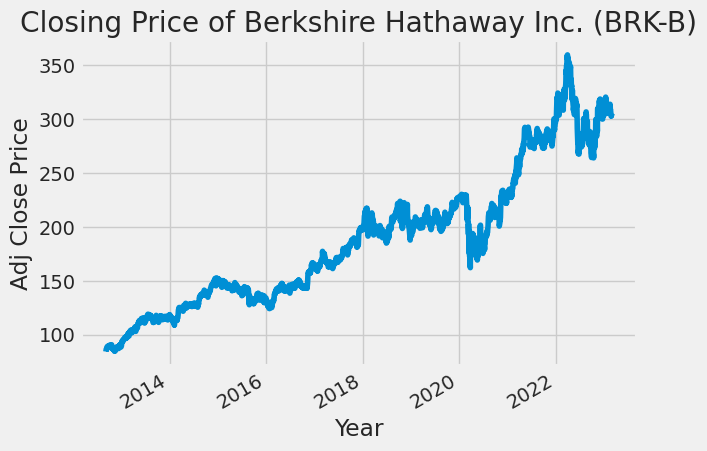

In [8]:

df['Adj Close'].plot()
plt.title("Closing Price of Berkshire Hathaway Inc. (BRK-B)");
plt.xlabel("Year")
plt.ylabel("Adj Close Price")
plt.show()

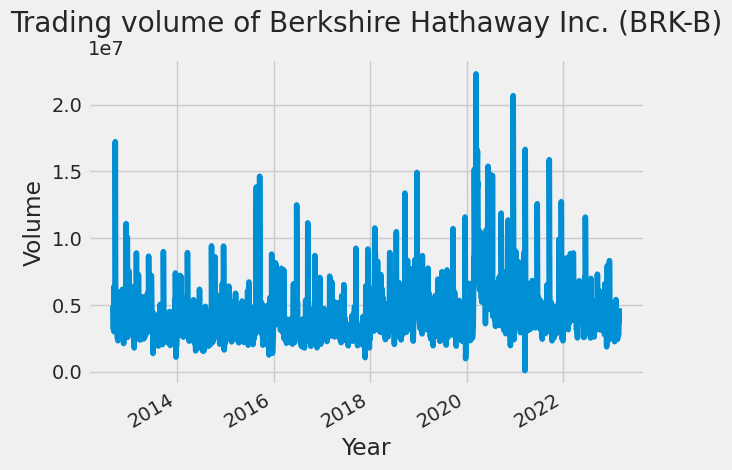

In [9]:
df['Volume'].plot()
plt.title("Trading volume of Berkshire Hathaway Inc. (BRK-B)");
plt.xlabel("Year")
plt.ylabel("Volume")
plt.show()

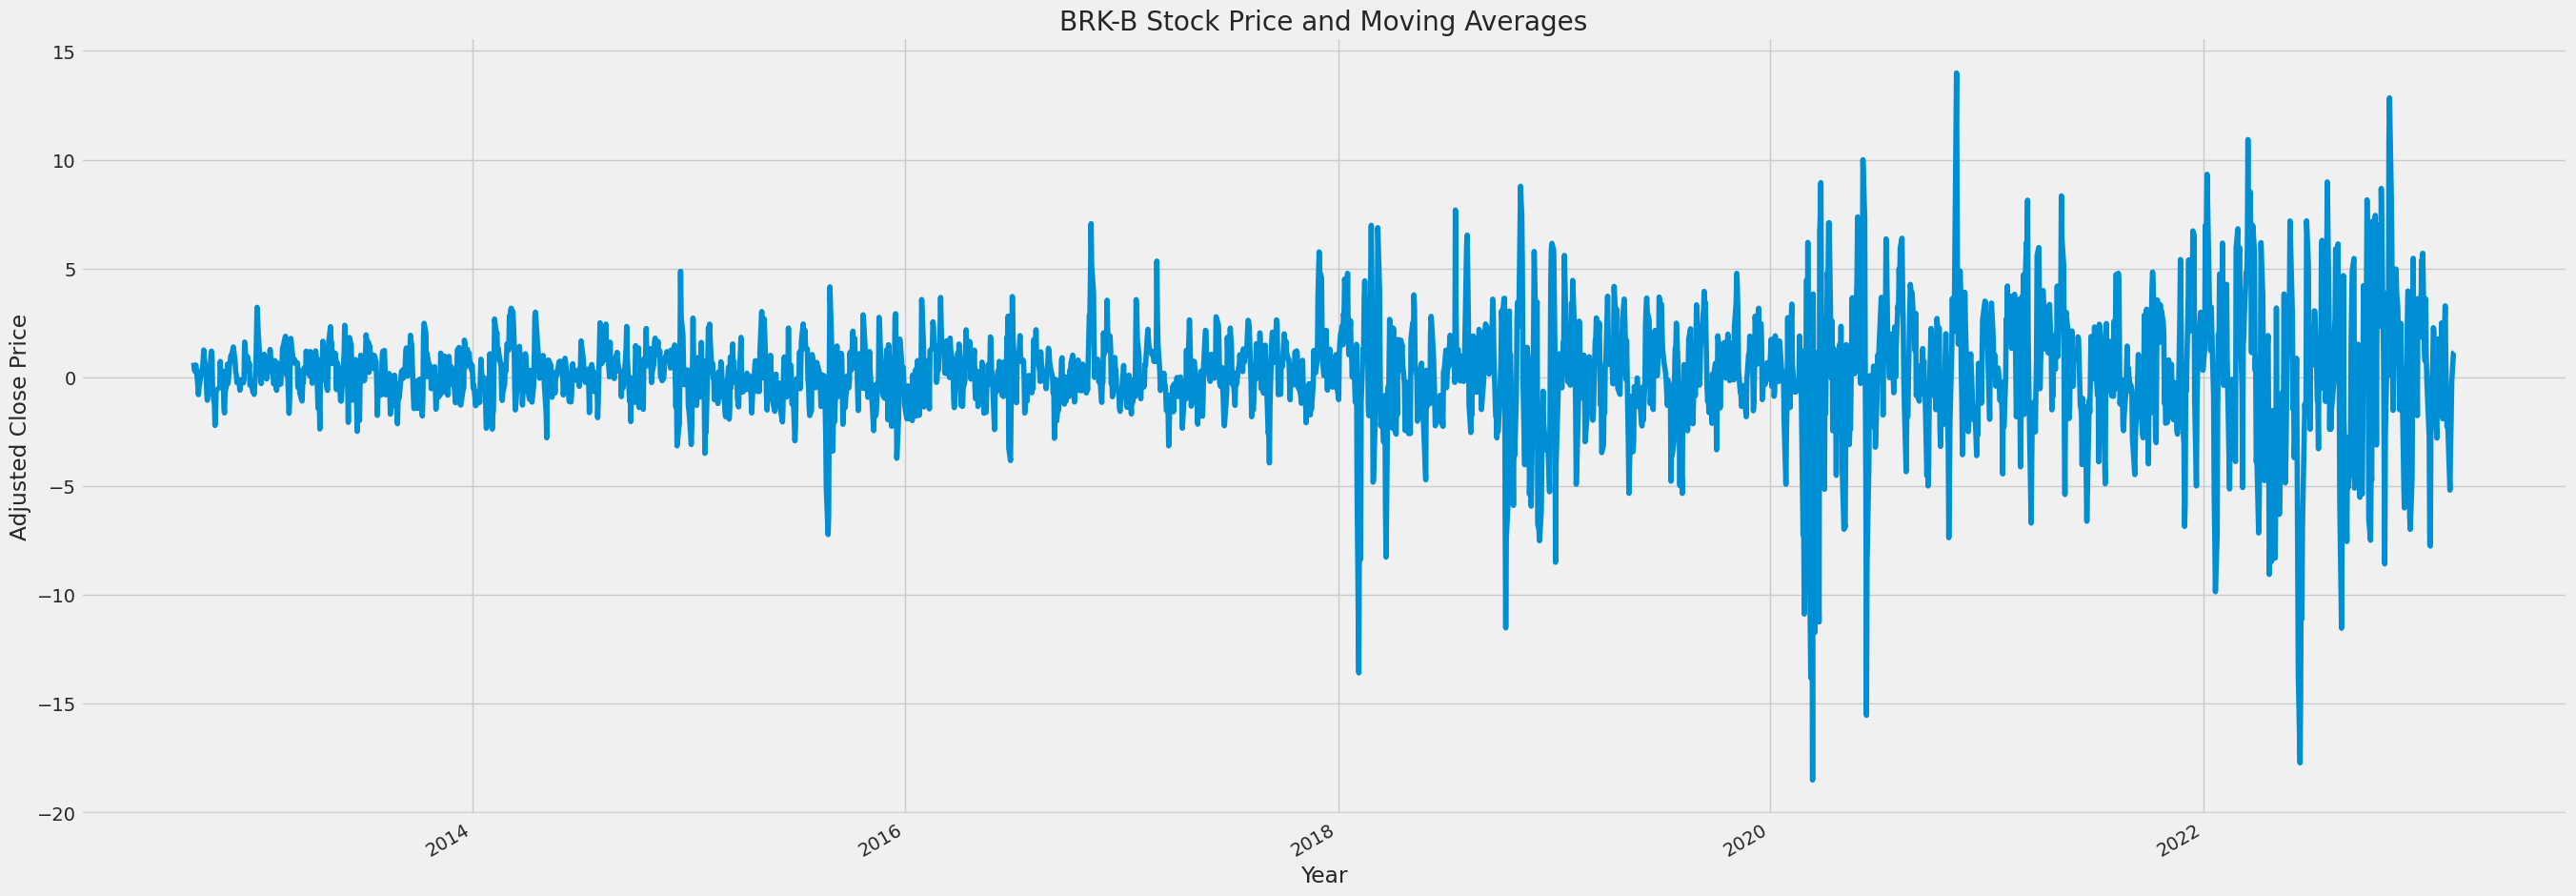

In [10]:
# Assuming 'df' is your DataFrame and 'Adj Close' is the stock price column

# Calculate Moving Averages
df['MA for 5 days'] = df['Adj Close'].rolling(window=5).mean()
df['MA for 10 days'] = df['Adj Close'].rolling(window=10).mean()

# Create new columns for the differences
df['Price - MA5'] = df['Adj Close'] - df['MA for 5 days']
df['Price - MA10'] = df['Adj Close'] - df['MA for 10 days']

# Remove rows with NaN values in the newly created columns
df.dropna(subset=['Price - MA5', 'Price - MA10'], inplace=True)

# Plotting
plt.figure(figsize=(30, 12))
df['Price - MA5'].plot()
plt.title('BRK-B Stock Price and Moving Averages')
plt.xlabel('Year')
plt.ylabel('Adjusted Close Price')
plt.show()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2629 entries, 2012-09-17 to 2023-02-28
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Open            2629 non-null   float64
 1   High            2629 non-null   float64
 2   Low             2629 non-null   float64
 3   Close           2629 non-null   float64
 4   Adj Close       2629 non-null   float64
 5   Volume          2629 non-null   int64  
 6   MA for 5 days   2629 non-null   float64
 7   MA for 10 days  2629 non-null   float64
 8   Price - MA5     2629 non-null   float64
 9   Price - MA10    2629 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 225.9 KB


## Scaling and Normalization

In [12]:
from sklearn.preprocessing import MinMaxScaler
# split data in 8:1:1 train/validation/test sets
valid_split= 0.1
test_split= 0.1

# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = MinMaxScaler()
    # Apply the scaler to the DataFrame
    df_normalized = pd.DataFrame(min_max_scaler.fit_transform(df), columns=df.columns, index=df.index)
    return df_normalized, min_max_scaler

def load_data(stock, seq_len):
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(stock) - seq_len):
        data.append(stock[index: index + seq_len])

    data = np.array(data)
    valid_set_size = int(np.round(valid_split*data.shape[0]))
    test_set_size = int(np.round(test_split*data.shape[0]))
    train_set_size = data.shape[0] - (valid_set_size + test_set_size)


    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]

    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]

    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

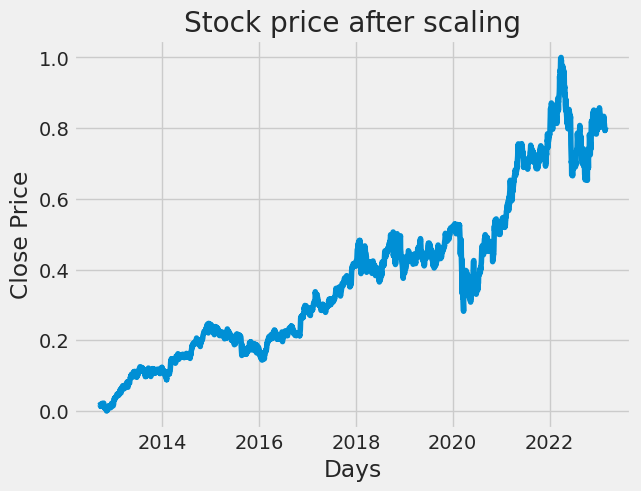

In [13]:
# normalize stock
df_norm, scaler = normalize_data(df["Adj Close"].to_frame())
#plot stock price
plt.plot(df_norm['Adj Close'])
plt.xlabel("Days")
plt.ylabel("Close Price")
plt.title("Stock price after scaling")
plt.show()

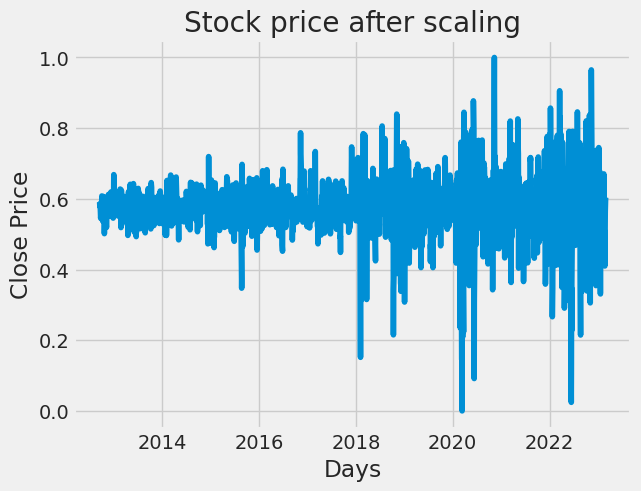

In [14]:
# update scaler
df_norm, scaler = normalize_data(df['Price - MA5'].to_frame())
#plot Adj_price w MA5
plt.plot(df_norm['Price - MA5'])
plt.xlabel("Days")
plt.ylabel("Close Price")
plt.title("Stock price after scaling")
plt.show()

In [17]:
seq_len = 21 # average trading days for one month
X_train, y_train, X_valid, y_valid,X_test, y_test = load_data(df_norm, seq_len)
print('x_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_valid.shape = ',X_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2086, 20, 1)
y_train.shape =  (2086, 1)
X_valid.shape =  (261, 20, 1)
y_valid.shape =  (261, 1)
X_test.shape =  (261, 20, 1)
y_test.shape =  (261, 1)


## Construct Models

In [18]:
# RNN Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

model = Sequential()

# Adding the first RNN layer and Dropout regularisation
model.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second RNN layer and Dropout regularisation.
model.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
model.add(Dropout(0.2))

# Adding a third RNN layer and Dropout regularisation.
model.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth RNN layer and Dropout regularisation.
model.add(SimpleRNN(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
simple_rnn_history = model.fit(X_train, y_train, epochs = 100, batch_size = 32)


Epoch 1/100
66/66 [==============================] - 12s 49ms/step - loss: 0.4125
Epoch 2/100
66/66 [==============================] - 3s 51ms/step - loss: 0.1933
Epoch 3/100
66/66 [==============================] - 3s 49ms/step - loss: 0.1226
Epoch 4/100
66/66 [==============================] - 3s 50ms/step - loss: 0.0767
Epoch 5/100
66/66 [==============================] - 3s 50ms/step - loss: 0.0654
Epoch 6/100
66/66 [==============================] - 3s 50ms/step - loss: 0.0463
Epoch 7/100
66/66 [==============================] - 3s 48ms/step - loss: 0.0408
Epoch 8/100
66/66 [==============================] - 3s 49ms/step - loss: 0.0348
Epoch 9/100
66/66 [==============================] - 3s 50ms/step - loss: 0.0275
Epoch 10/100
66/66 [==============================] - 3s 48ms/step - loss: 0.0263
Epoch 11/100
66/66 [==============================] - 3s 47ms/step - loss: 0.0223
Epoch 12/100
66/66 [==============================] - 3s 47ms/step - loss: 0.0209
Epoch 13/100
66/66 [====

In [19]:
import math
min_loss = np.min(simple_rnn_history.history["loss"])
RMSE = math.sqrt(min_loss)
RMSE

0.05477776273520797

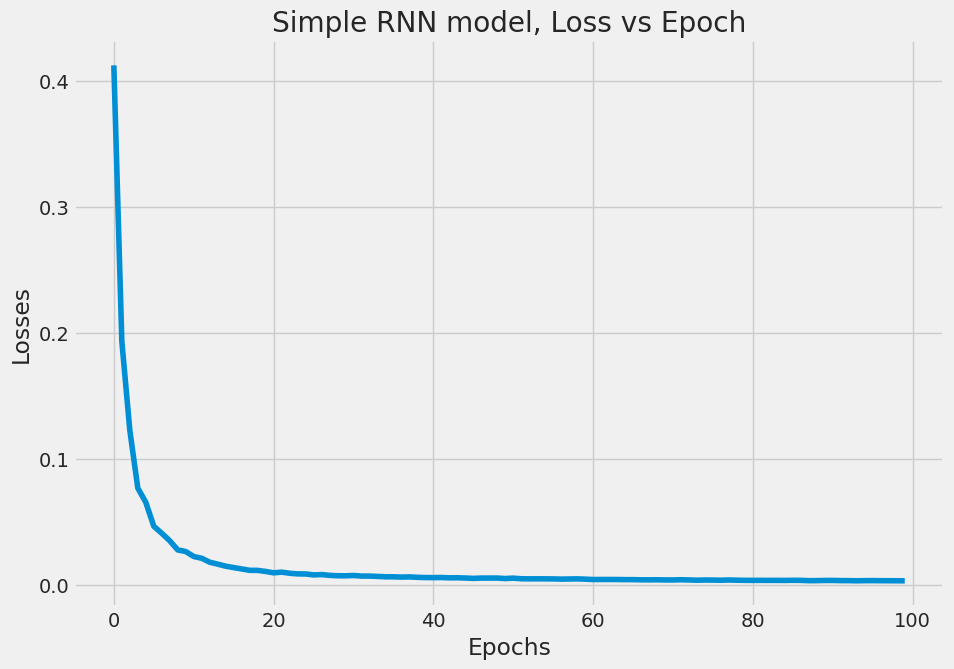

In [20]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(simple_rnn_history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Simple RNN model, Loss vs Epoch")
plt.show()

In [21]:
predicted_data_valid = model.predict(X_valid)
predicted_data_valid = scaler.inverse_transform(predicted_data_valid)
y_valid = scaler.inverse_transform(y_valid)

9/9 [==============================] - 0s 8ms/step


In [22]:
rmse = np.sqrt(np.mean(((predicted_data_valid - y_valid) ** 2)))
print("rmse validation set: ", rmse)

rmse validation set:  2.2920173042294225


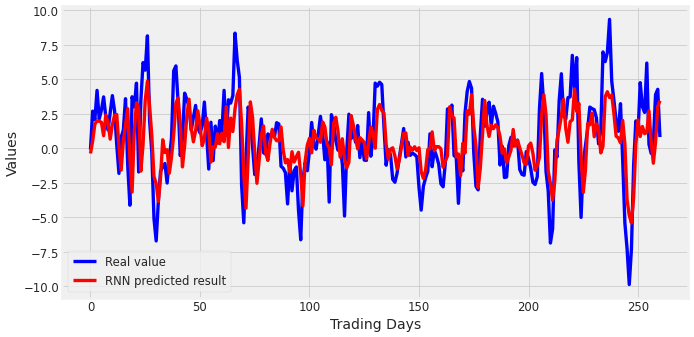

In [23]:
plt.figure(figsize=(12,6), dpi=60, facecolor='w', edgecolor='k')
plt.plot(y_valid,color="blue",label="Real value")
plt.plot(predicted_data_valid,color="r",label="RNN predicted result")
plt.legend()
plt.xlabel("Trading Days")
plt.ylabel("Values")
plt.grid(True)
plt.show()

### Construct LSTM model

In [24]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

model1 = Sequential()
model1.add(LSTM(10, input_shape=(None,1)))
model1.add(Dense(1))
model1.compile(loss="mean_squared_error",optimizer='Adam')
lstm_history=model1.fit(X_train,y_train,epochs=50, batch_size=1)

Epoch 1/50
2086/2086 [==============================] - 9s 3ms/step - loss: 0.0069
Epoch 2/50
2086/2086 [==============================] - 6s 3ms/step - loss: 0.0042
Epoch 3/50
2086/2086 [==============================] - 6s 3ms/step - loss: 0.0037
Epoch 4/50
2086/2086 [==============================] - 6s 3ms/step - loss: 0.0034
Epoch 5/50
2086/2086 [==============================] - 6s 3ms/step - loss: 0.0033
Epoch 6/50
2086/2086 [==============================] - 6s 3ms/step - loss: 0.0031
Epoch 7/50
2086/2086 [==============================] - 6s 3ms/step - loss: 0.0030
Epoch 8/50
2086/2086 [==============================] - 6s 3ms/step - loss: 0.0029
Epoch 9/50
2086/2086 [==============================] - 6s 3ms/step - loss: 0.0029
Epoch 10/50
2086/2086 [==============================] - 6s 3ms/step - loss: 0.0029
Epoch 11/50
2086/2086 [==============================] - 6s 3ms/step - loss: 0.0029
Epoch 12/50
2086/2086 [==============================] - 6s 3ms/step - loss: 0.0029
E

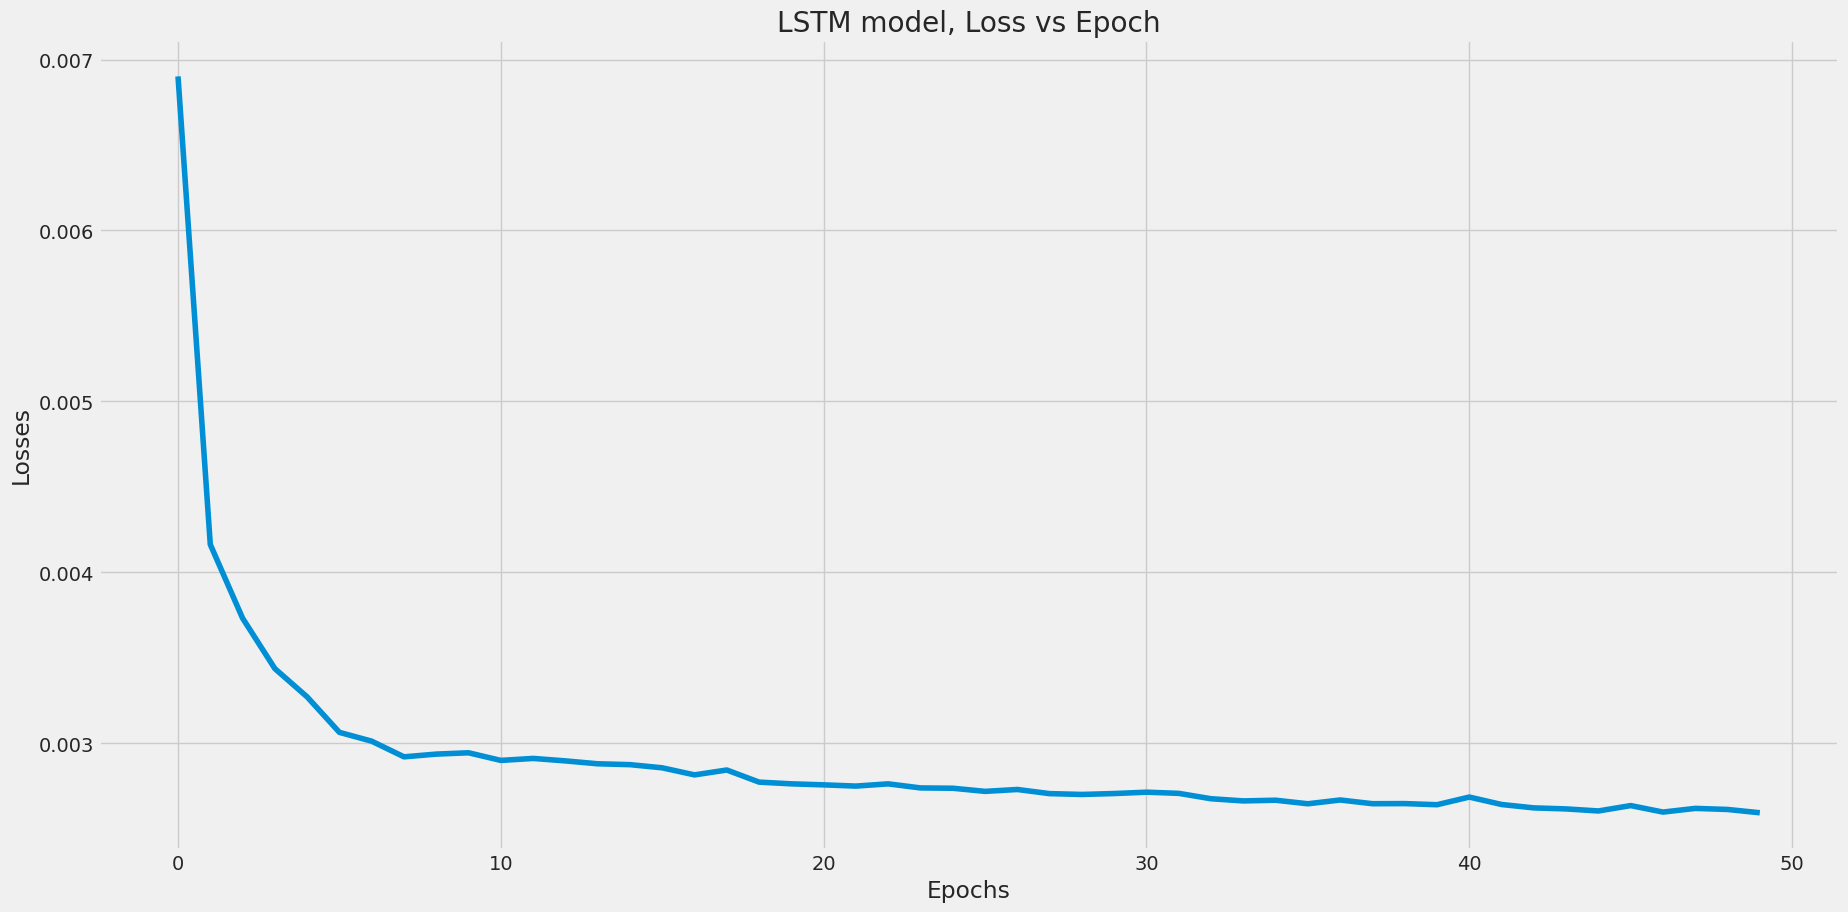

In [25]:
plt.figure(figsize =(20,10))
plt.plot(lstm_history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("LSTM model, Loss vs Epoch")
plt.show()

In [26]:
predicted_data_valid2=model1.predict(X_valid)
predicted_data_valid2=scaler.inverse_transform(predicted_data_valid2)

9/9 [==============================] - 0s 2ms/step


In [27]:
min_loss = np.min(lstm_history.history['loss'])
RMSE = math.sqrt(min_loss)
RMSE

0.050937483321666914

In [28]:
rmse = np.sqrt(np.mean(((predicted_data_valid2 - y_valid) ** 2)))
print("rmse validation set: ", rmse)

rmse validation set:  2.253445778161014


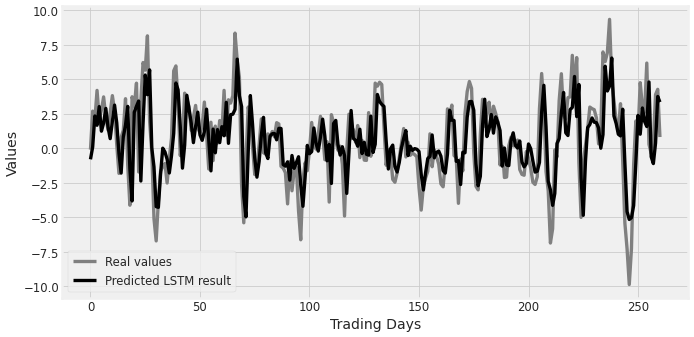

In [29]:
plt.figure(figsize=(12,6), dpi=60, facecolor='w', edgecolor='k')
plt.plot(y_valid,color="Grey",label="Real values")
plt.plot(predicted_data_valid2,color="Black",label="Predicted LSTM result")
plt.legend()
plt.xlabel("Trading Days")
plt.ylabel("Values")
plt.grid(True)
plt.show()

## Comaparison

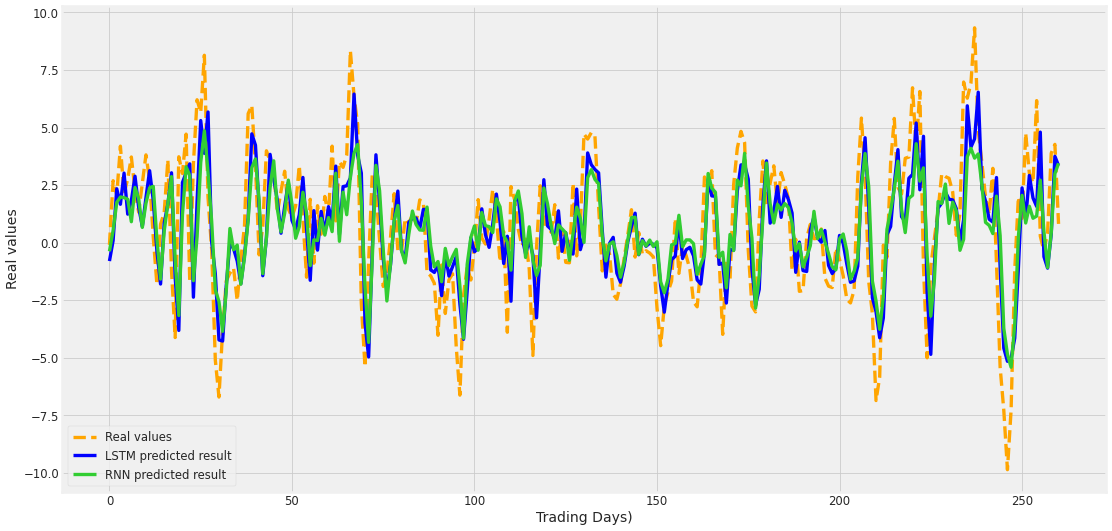

In [30]:
plt.figure(figsize=(20,10), dpi=60, facecolor='w', edgecolor='k')
plt.plot(y_valid,color="Orange", linestyle='dashed',label="Real values")
plt.plot(predicted_data_valid2,color="blue", label="LSTM predicted result")
plt.plot(predicted_data_valid,color="LimeGreen",label="RNN predicted result") #
plt.legend()
plt.xlabel("Trading Days)")
plt.ylabel("Real values")
plt.grid(True)
plt.show()

## Experimental Analysis

In [31]:
# create train, test data
seq_len_10 = 10 # choose sequence length
X_train_10, y_train_10, X_valid_10, y_valid_10,X_test_10, y_test_10 = load_data(df_norm, seq_len_10)

In [32]:
model_10 = Sequential()
model_10.add(LSTM(10, input_shape=(None,1)))
model_10.add(Dense(1))
model_10.compile(loss="mean_squared_error",optimizer='Adam')
lstm_history_10=model_10.fit(X_train_10,y_train_10,epochs=50, batch_size=1)

Epoch 1/50
2095/2095 [==============================] - 7s 3ms/step - loss: 0.0109
Epoch 2/50
2095/2095 [==============================] - 6s 3ms/step - loss: 0.0041
Epoch 3/50
2095/2095 [==============================] - 6s 3ms/step - loss: 0.0038
Epoch 4/50
2095/2095 [==============================] - 6s 3ms/step - loss: 0.0035
Epoch 5/50
2095/2095 [==============================] - 6s 3ms/step - loss: 0.0033
Epoch 6/50
2095/2095 [==============================] - 6s 3ms/step - loss: 0.0032
Epoch 7/50
2095/2095 [==============================] - 6s 3ms/step - loss: 0.0031
Epoch 8/50
2095/2095 [==============================] - 6s 3ms/step - loss: 0.0031
Epoch 9/50
2095/2095 [==============================] - 6s 3ms/step - loss: 0.0031
Epoch 10/50
2095/2095 [==============================] - 6s 3ms/step - loss: 0.0030
Epoch 11/50
2095/2095 [==============================] - 6s 3ms/step - loss: 0.0030
Epoch 12/50
2095/2095 [==============================] - 6s 3ms/step - loss: 0.0030
E

In [33]:
predicted_data_valid_10=model_10.predict(X_valid_10)
predicted_data_valid_10=scaler.inverse_transform(predicted_data_valid_10)
y_valid_10=scaler.inverse_transform(y_valid_10)

9/9 [==============================] - 0s 2ms/step


In [34]:
min_loss = np.min(lstm_history_10.history['loss'])
RMSE__10 = math.sqrt(min_loss)
RMSE__10

0.050987969141754304

In [36]:
rmse_10 = np.sqrt(np.mean(((predicted_data_valid_10 - y_valid_10) ** 2)))
print("rmse validation set: ", rmse_10)

rmse validation set:  2.2586226675132623


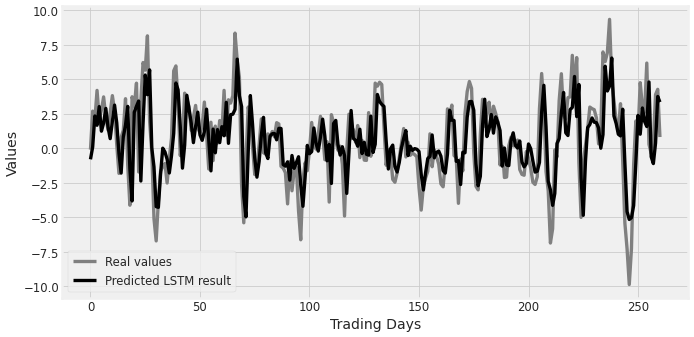

In [37]:
plt.figure(figsize=(12,6), dpi=60, facecolor='w', edgecolor='k')
plt.plot(y_valid,color="Grey",label="Real values")
plt.plot(predicted_data_valid2,color="Black",label="Predicted LSTM result")
plt.legend()
plt.xlabel("Trading Days")
plt.ylabel("Values")
plt.grid(True)
plt.show()

In [38]:
# create train, test data
seq_len_34 = 34 # choose sequence length
X_train_34, y_train_34, X_valid_34, y_valid_34,X_test_34, y_test_34 = load_data(df_norm, seq_len_34)


In [39]:
model_34 = Sequential()
model_34.add(LSTM(10, input_shape=(None,1)))
model_34.add(Dense(1))
model_34.compile(loss="mean_squared_error",optimizer='Adam')
lstm_history_34=model_34.fit(X_train_34,y_train_34,epochs=50, batch_size=1)

Epoch 1/50
2075/2075 [==============================] - 8s 3ms/step - loss: 0.0061
Epoch 2/50
2075/2075 [==============================] - 7s 3ms/step - loss: 0.0040
Epoch 3/50
2075/2075 [==============================] - 7s 3ms/step - loss: 0.0033
Epoch 4/50
2075/2075 [==============================] - 7s 3ms/step - loss: 0.0031
Epoch 5/50
2075/2075 [==============================] - 7s 3ms/step - loss: 0.0031
Epoch 6/50
2075/2075 [==============================] - 7s 3ms/step - loss: 0.0030
Epoch 7/50
2075/2075 [==============================] - 7s 3ms/step - loss: 0.0029
Epoch 8/50
2075/2075 [==============================] - 7s 3ms/step - loss: 0.0029
Epoch 9/50
2075/2075 [==============================] - 7s 3ms/step - loss: 0.0029
Epoch 10/50
2075/2075 [==============================] - 7s 3ms/step - loss: 0.0028
Epoch 11/50
2075/2075 [==============================] - 7s 3ms/step - loss: 0.0028
Epoch 12/50
2075/2075 [==============================] - 7s 3ms/step - loss: 0.0029
E

In [40]:
predicted_data_valid_34=model_34.predict(X_valid_34)
predicted_data_valid_34=scaler.inverse_transform(predicted_data_valid_34)
y_valid_34 = scaler.inverse_transform(y_valid_34)

9/9 [==============================] - 0s 2ms/step


In [41]:
min_loss = np.min(lstm_history_34.history['loss'])
RMSE = math.sqrt(min_loss)
RMSE

0.05058506519346136

In [42]:
rmse_34 = np.sqrt(np.mean(((predicted_data_valid_34 - y_valid_34) ** 2)))
print("rmse validation set: ", rmse_34)

rmse validation set:  2.243056076691669


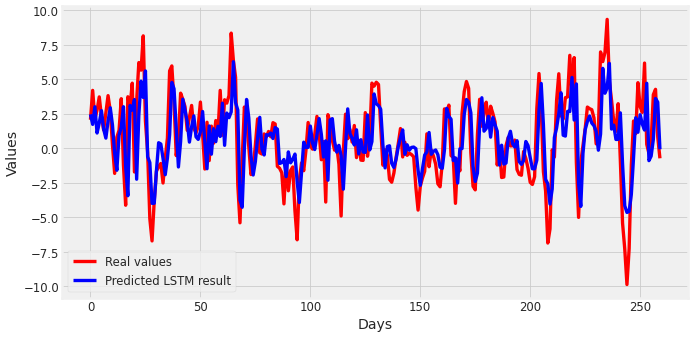

In [43]:
plt.figure(figsize=(12,6), dpi=60, facecolor='w', edgecolor='k')
plt.plot(y_valid_34,color="Red",label="Real values")
plt.plot(predicted_data_valid_34,color="Blue",label="Predicted LSTM result")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.grid(True)
plt.show()

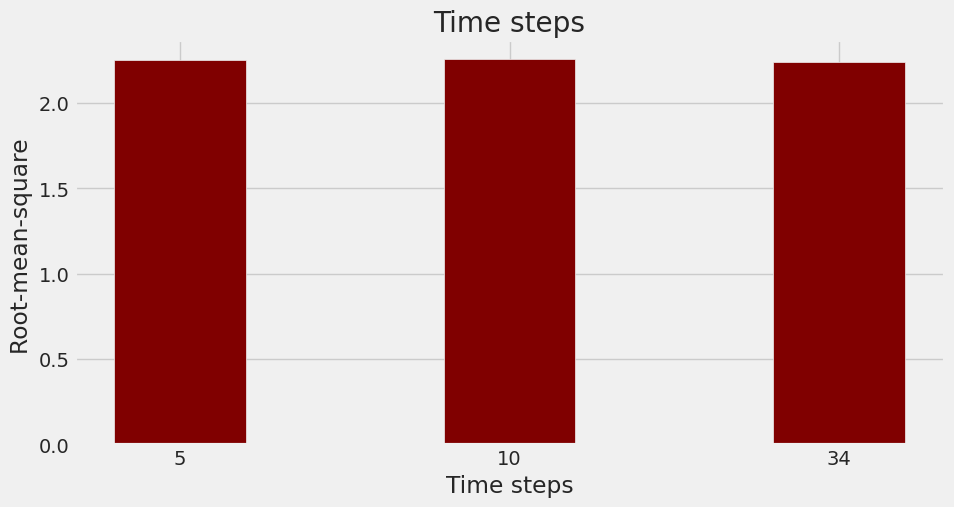

In [44]:
data = {'5':rmse, '10':rmse_10, '34':rmse_34}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)

plt.xlabel("Time steps")
plt.ylabel("Root-mean-square ")
plt.title("Time steps")
plt.show()

#Applying the best model to test set

In [45]:
predicted_test=model1.predict(X_test)
predicted_test=scaler.inverse_transform(predicted_test)
y_test = scaler.inverse_transform(y_test)

9/9 [==============================] - 0s 2ms/step


In [46]:
rmse = np.sqrt(np.mean(((predicted_test - y_test) ** 2)))
print("rmse test set: ", rmse)

rmse test set:  3.402185546867432


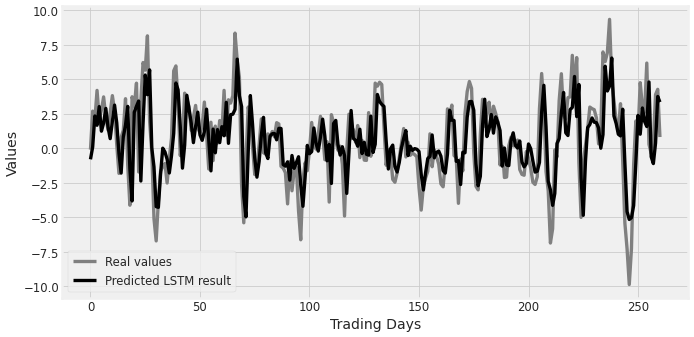

In [47]:
plt.figure(figsize=(12,6), dpi=60, facecolor='w', edgecolor='k')
plt.plot(y_valid,color="Grey",label="Real values")
plt.plot(predicted_data_valid2,color="Black",label="Predicted LSTM result")
plt.legend()
plt.xlabel("Trading Days")
plt.ylabel("Values")
plt.grid(True)
plt.show()

# Future price prediction

In [48]:
df.iloc[-1]

Open              3.048900e+02
High              3.061500e+02
Low               3.034100e+02
Close             3.051800e+02
Adj Close         3.051800e+02
Volume            4.736800e+06
MA for 5 days     3.040180e+02
MA for 10 days    3.059650e+02
Price - MA5       1.161993e+00
Price - MA10     -7.850067e-01
Name: 2023-02-28 00:00:00, dtype: float64

In [49]:
X_input = df.iloc[-seq_len:].Open.values               # getting last 20 rows and converting to array
X_input = scaler.fit_transform(X_input.reshape(-1,1))      # converting to 2D array and scaling
X_input = np.reshape(X_input, (1,seq_len,1))                    # reshaping : converting to 3D array
print("Shape of X_input :", X_input.shape)
X_input

Shape of X_input : (1, 21, 1)


array([[[0.53811731],
        [0.5485795 ],
        [0.68983614],
        [0.89312465],
        [0.79222737],
        [0.5866968 ],
        [0.51569442],
        [0.80119561],
        [0.73019551],
        [0.49925189],
        [0.73990959],
        [1.        ],
        [0.71599504],
        [0.53662108],
        [0.50448412],
        [0.43124196],
        [0.20926886],
        [0.34454516],
        [0.        ],
        [0.29671149],
        [0.33557691]]])

In [50]:
LSTM_prediction = scaler.inverse_transform(model1.predict(X_input))
print("LSTM prediction, Open price prediction for last trading day :", LSTM_prediction[0,0])

1/1 [==============================] - 0s 330ms/step
LSTM prediction, Open price prediction for last trading day : 305.69824
